<a href="https://colab.research.google.com/github/vivekdev-empa/Insitu_tensile_hackathon2025/blob/main/Crack_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import numpy as np
from pathlib import Path

# Mount Drive
drive.mount('/content/drive')

# Set paths
base_path = Path('/content/drive/MyDrive/Crack_tracking')
data_path = base_path / 'data' / '1508 20250613 105 kx Ceta Camera.npy'
annotation_path = base_path / 'annotations'

# Load annotations
sample_name = "1508_20250613_105_kx_Ceta_Camera"

masks = np.load(annotation_path / f'{sample_name}_annotated_masks.npy')
frame_indices = np.load(annotation_path / f'{sample_name}_frame_indices.npy')

print("✅ Successfully loaded annotations!")
print(f"   Masks shape: {masks.shape}")
print(f"   Number of annotated frames: {len(frame_indices)}")
print(f"   Frame indices: {frame_indices[:5]}...{frame_indices[-5:]}")
print(f"   Total annotated pixels: {masks.sum():,}")

# Load original frames
frames = np.load(data_path, mmap_mode='r')
print(f"\n✅ Original data loaded!")
print(f"   Total frames: {frames.shape[0]}")
print(f"   Frame size: {frames.shape[1]} x {frames.shape[2]}")

Mounted at /content/drive
✅ Successfully loaded annotations!
   Masks shape: (53, 1024, 1024)
   Number of annotated frames: 53
   Frame indices: [ 0 20 40 60 80]...[760 780 800 820 840]
   Total annotated pixels: 57,954

✅ Original data loaded!
   Total frames: 855
   Frame size: 1024 x 1024


In [2]:
from sklearn.model_selection import train_test_split

# Split: 70% train, 15% validation, 15% test
train_idx, temp_idx = train_test_split(
    np.arange(len(masks)),
    test_size=0.3,
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=42
)

print(f"Dataset split:")
print(f"  Training: {len(train_idx)} frames ({len(train_idx)/len(masks)*100:.1f}%)")
print(f"  Validation: {len(val_idx)} frames ({len(val_idx)/len(masks)*100:.1f}%)")
print(f"  Test: {len(test_idx)} frames ({len(test_idx)/len(masks)*100:.1f}%)")

# Save split for reproducibility
np.save(annotation_path / f'{sample_name}_train_idx.npy', train_idx)
np.save(annotation_path / f'{sample_name}_val_idx.npy', val_idx)
np.save(annotation_path / f'{sample_name}_test_idx.npy', test_idx)

print("\n✅ Train/val/test split saved!")

Dataset split:
  Training: 37 frames (69.8%)
  Validation: 8 frames (15.1%)
  Test: 8 frames (15.1%)

✅ Train/val/test split saved!


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CrackDataset(Dataset):
    """Dataset for crack segmentation"""

    def __init__(self, frames, masks, frame_indices, indices, transform=None):
        """
        Args:
            frames: Full frame array (memory-mapped)
            masks: Annotated masks
            frame_indices: Which frames were annotated
            indices: Train/val/test split indices
            transform: Augmentation pipeline
        """
        self.frames = frames
        self.masks = masks[indices]
        self.frame_indices = frame_indices[indices]
        self.transform = transform

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        # Get frame and mask
        frame_num = self.frame_indices[idx]
        image = self.frames[frame_num].astype(np.float32)
        mask = self.masks[idx].astype(np.float32)

        # Normalize image to [0, 1]
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        # Add channel dimension for grayscale
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Ensure mask is C, H, W format after ToTensorV2 converts (H, W, C) numpy to (H, W, C) torch
        if isinstance(mask, torch.Tensor) and mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask.permute(2, 0, 1) # Convert H, W, C to C, H, W

        return image, mask

# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    ToTensorV2(),
])

val_transform = A.Compose([
    ToTensorV2(),
])

# Create datasets
train_dataset = CrackDataset(frames, masks, frame_indices, train_idx, transform=train_transform)
val_dataset = CrackDataset(frames, masks, frame_indices, val_idx, transform=val_transform)
test_dataset = CrackDataset(frames, masks, frame_indices, test_idx, transform=val_transform)

# Create dataloaders
batch_size = 4  # Adjust based on GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"✅ Datasets created!")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

✅ Datasets created!
   Training batches: 10
   Validation batches: 2
   Test batches: 2


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3536098089.py:58: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [5]:
# Install deep learning packages
!pip install torch torchvision segmentation-models-pytorch albumentations tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.7 MB/s eta 0:00:00


In [6]:
import segmentation_models_pytorch as smp

# Create U-Net model with pretrained encoder
model = smp.Unet(
    encoder_name="resnet34",        # Pretrained encoder
    encoder_weights="imagenet",     # Use ImageNet pretrained weights
    in_channels=1,                  # Grayscale input
    classes=1,                      # Binary segmentation
    activation=None,                # We'll use sigmoid in loss
)

# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"✅ Model created!")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Device: {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✅ Model created!
   Parameters: 24,430,097
   Device: cuda


In [7]:
import torch.nn as nn

class DiceBCELoss(nn.Module):
    """Combined Dice Loss and Binary Cross Entropy"""

    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        super().__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        # BCE loss
        bce_loss = self.bce(inputs, targets)

        # Dice loss
        inputs_sigmoid = torch.sigmoid(inputs)
        smooth = 1e-5

        intersection = (inputs_sigmoid * targets).sum(dim=(2, 3))
        union = inputs_sigmoid.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_loss = 1 - dice.mean()

        # Combined loss
        return self.weight_bce * bce_loss + self.weight_dice * dice_loss

# Loss and optimizer
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)

print("✅ Loss function and optimizer ready!")

✅ Loss function and optimizer ready!


In [8]:
from tqdm.notebook import tqdm

def calculate_iou(pred, target, threshold=0.5):
    """Calculate Intersection over Union"""
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_iou = 0

    pbar = tqdm(loader, desc="Training")
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        with torch.no_grad():
            iou = calculate_iou(torch.sigmoid(outputs), masks)
            total_iou += iou

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'iou': f'{iou:.4f}'})

    return total_loss / len(loader), total_iou / len(loader)

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            iou = calculate_iou(torch.sigmoid(outputs), masks)
            total_iou += iou

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'iou': f'{iou:.4f}'})

    return total_loss / len(loader), total_iou / len(loader)

print("✅ Training functions ready!")

✅ Training functions ready!


In [9]:
# Training configuration
num_epochs = 50
best_val_iou = 0

# Results path
results_path = base_path / 'results'
results_path.mkdir(exist_ok=True)

# Training history
history = {
    'train_loss': [],
    'train_iou': [],
    'val_loss': [],
    'val_iou': []
}

print("🚀 Starting training...")
print("="*60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)

    # Train
    train_loss, train_iou = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_iou = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Val IoU:   {val_iou:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': val_iou,
            'val_loss': val_loss
        }, results_path / f'{sample_name}_best_model.pth')
        print(f"  ✅ New best model saved! (IoU: {val_iou:.4f})")

print("\n" + "="*60)
print(f"✅ Training complete!")
print(f"   Best validation IoU: {best_val_iou:.4f}")

🚀 Starting training...

Epoch 1/50
------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

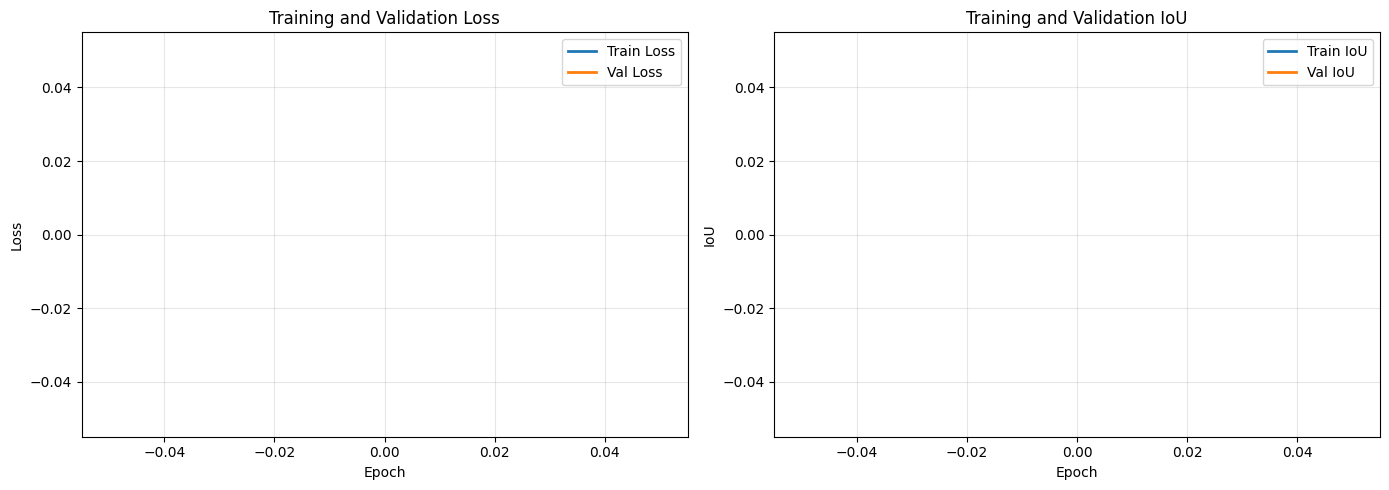

Final metrics:


IndexError: list index out of range

In [10]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# IoU plot
axes[1].plot(history['train_iou'], label='Train IoU', linewidth=2)
axes[1].plot(history['val_iou'], label='Val IoU', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training and Validation IoU')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_path / 'training_history.png', dpi=150)
plt.show()

print(f"Final metrics:")
print(f"  Train IoU: {history['train_iou'][-1]:.4f}")
print(f"  Val IoU: {history['val_iou'][-1]:.4f}")
print(f"  Best Val IoU: {best_val_iou:.4f}")

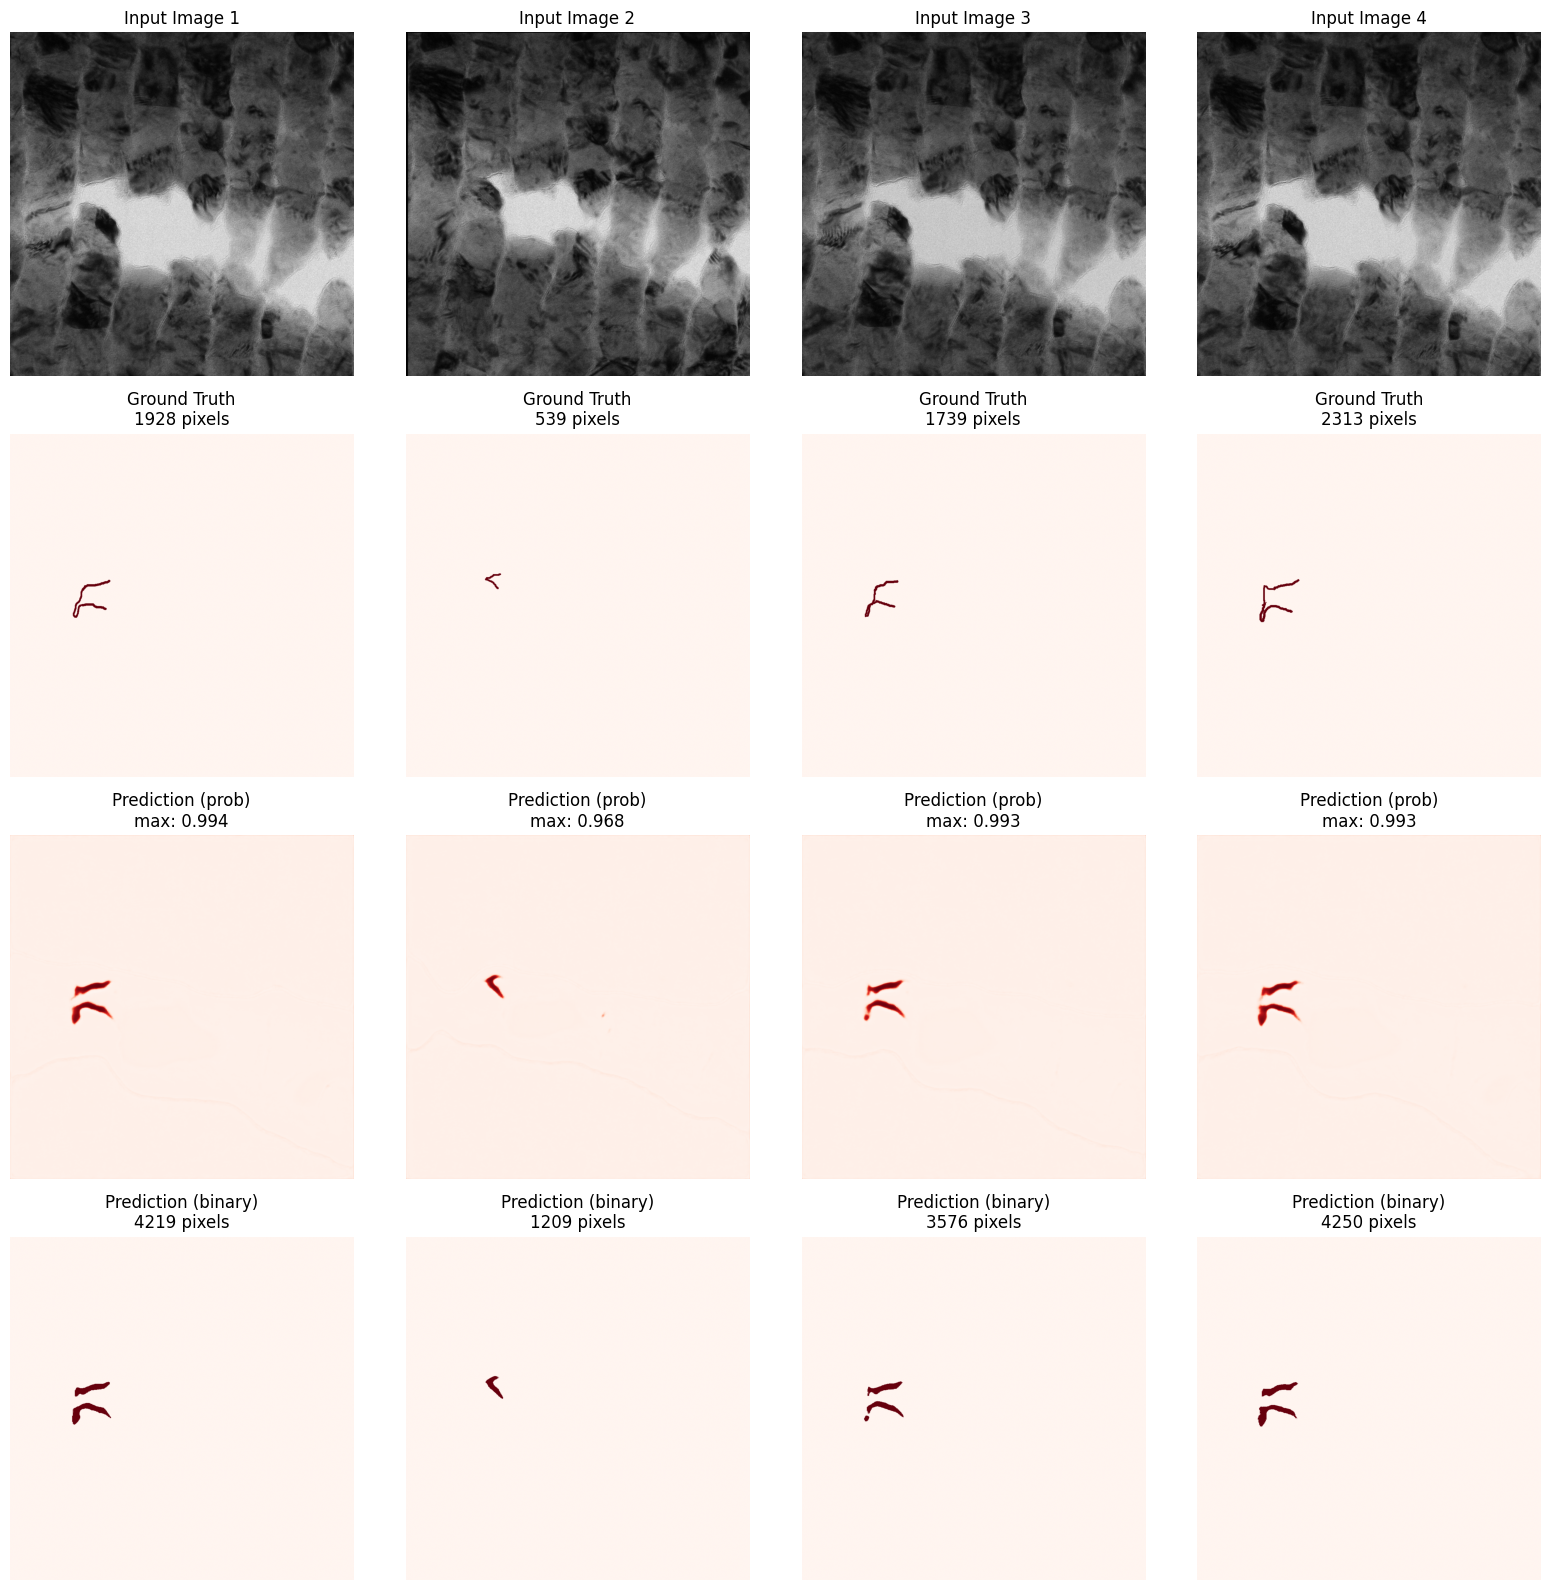

Look at the predictions:
  - Row 2: Ground truth (your annotations)
  - Row 3: Model's probability map (0-1)
  - Row 4: Binary prediction (threshold 0.5)


In [26]:
# Load best model
checkpoint = torch.load(results_path / f'{sample_name}_best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Get validation samples
val_images, val_masks = next(iter(val_loader))
val_images = val_images.to(device)

with torch.no_grad():
    predictions = torch.sigmoid(model(val_images))
    predictions_binary = (predictions > 0.5).float()  # Threshold at 0.5

# Visualize
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(min(4, len(val_images))):
    # Original image
    axes[0, i].imshow(val_images[i, 0].cpu().numpy(), cmap='gray')
    axes[0, i].set_title(f'Input Image {i+1}')
    axes[0, i].axis('off')

    # Ground truth
    gt = val_masks[i, 0].cpu().numpy()
    axes[1, i].imshow(gt, cmap='Reds')
    axes[1, i].set_title(f'Ground Truth\n{gt.sum():.0f} pixels')
    axes[1, i].axis('off')

    # Prediction (probability)
    pred = predictions[i, 0].cpu().numpy()
    axes[2, i].imshow(pred, cmap='Reds', vmin=0, vmax=1)
    axes[2, i].set_title(f'Prediction (prob)\nmax: {pred.max():.3f}')
    axes[2, i].axis('off')

    # Prediction (binary)
    pred_bin = predictions_binary[i, 0].cpu().numpy()
    axes[3, i].imshow(pred_bin, cmap='Reds')
    axes[3, i].set_title(f'Prediction (binary)\n{pred_bin.sum():.0f} pixels')
    axes[3, i].axis('off')

plt.tight_layout()
plt.savefig(results_path / 'current_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Look at the predictions:")
print("  - Row 2: Ground truth (your annotations)")
print("  - Row 3: Model's probability map (0-1)")
print("  - Row 4: Binary prediction (threshold 0.5)")

In [27]:
# Find optimal threshold on validation set
from sklearn.metrics import f1_score
import numpy as np

def find_optimal_threshold(model, val_loader, device):
    """Find threshold that maximizes IoU"""
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images))

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Test different thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_iou = 0
    best_threshold = 0.5

    print("Testing thresholds...")
    for thresh in thresholds:
        pred_binary = (all_preds > thresh).astype(np.float32)

        intersection = (pred_binary * all_targets).sum()
        union = pred_binary.sum() + all_targets.sum() - intersection
        iou = intersection / (union + 1e-6)

        print(f"  Threshold {thresh:.2f}: IoU = {iou:.4f}")

        if iou > best_iou:
            best_iou = iou
            best_threshold = thresh

    print(f"\n✅ Optimal threshold: {best_threshold:.2f}")
    print(f"   Best IoU: {best_iou:.4f}")

    return best_threshold, best_iou

# Find optimal threshold
optimal_threshold, optimal_iou = find_optimal_threshold(model, val_loader, device)

Testing thresholds...
  Threshold 0.10: IoU = 0.2049
  Threshold 0.15: IoU = 0.3051
  Threshold 0.20: IoU = 0.3270
  Threshold 0.25: IoU = 0.3412
  Threshold 0.30: IoU = 0.3510
  Threshold 0.35: IoU = 0.3602
  Threshold 0.40: IoU = 0.3668
  Threshold 0.45: IoU = 0.3733
  Threshold 0.50: IoU = 0.3800
  Threshold 0.55: IoU = 0.3865
  Threshold 0.60: IoU = 0.3925
  Threshold 0.65: IoU = 0.3987
  Threshold 0.70: IoU = 0.4054
  Threshold 0.75: IoU = 0.4118
  Threshold 0.80: IoU = 0.4172
  Threshold 0.85: IoU = 0.4070

✅ Optimal threshold: 0.80
   Best IoU: 0.4172


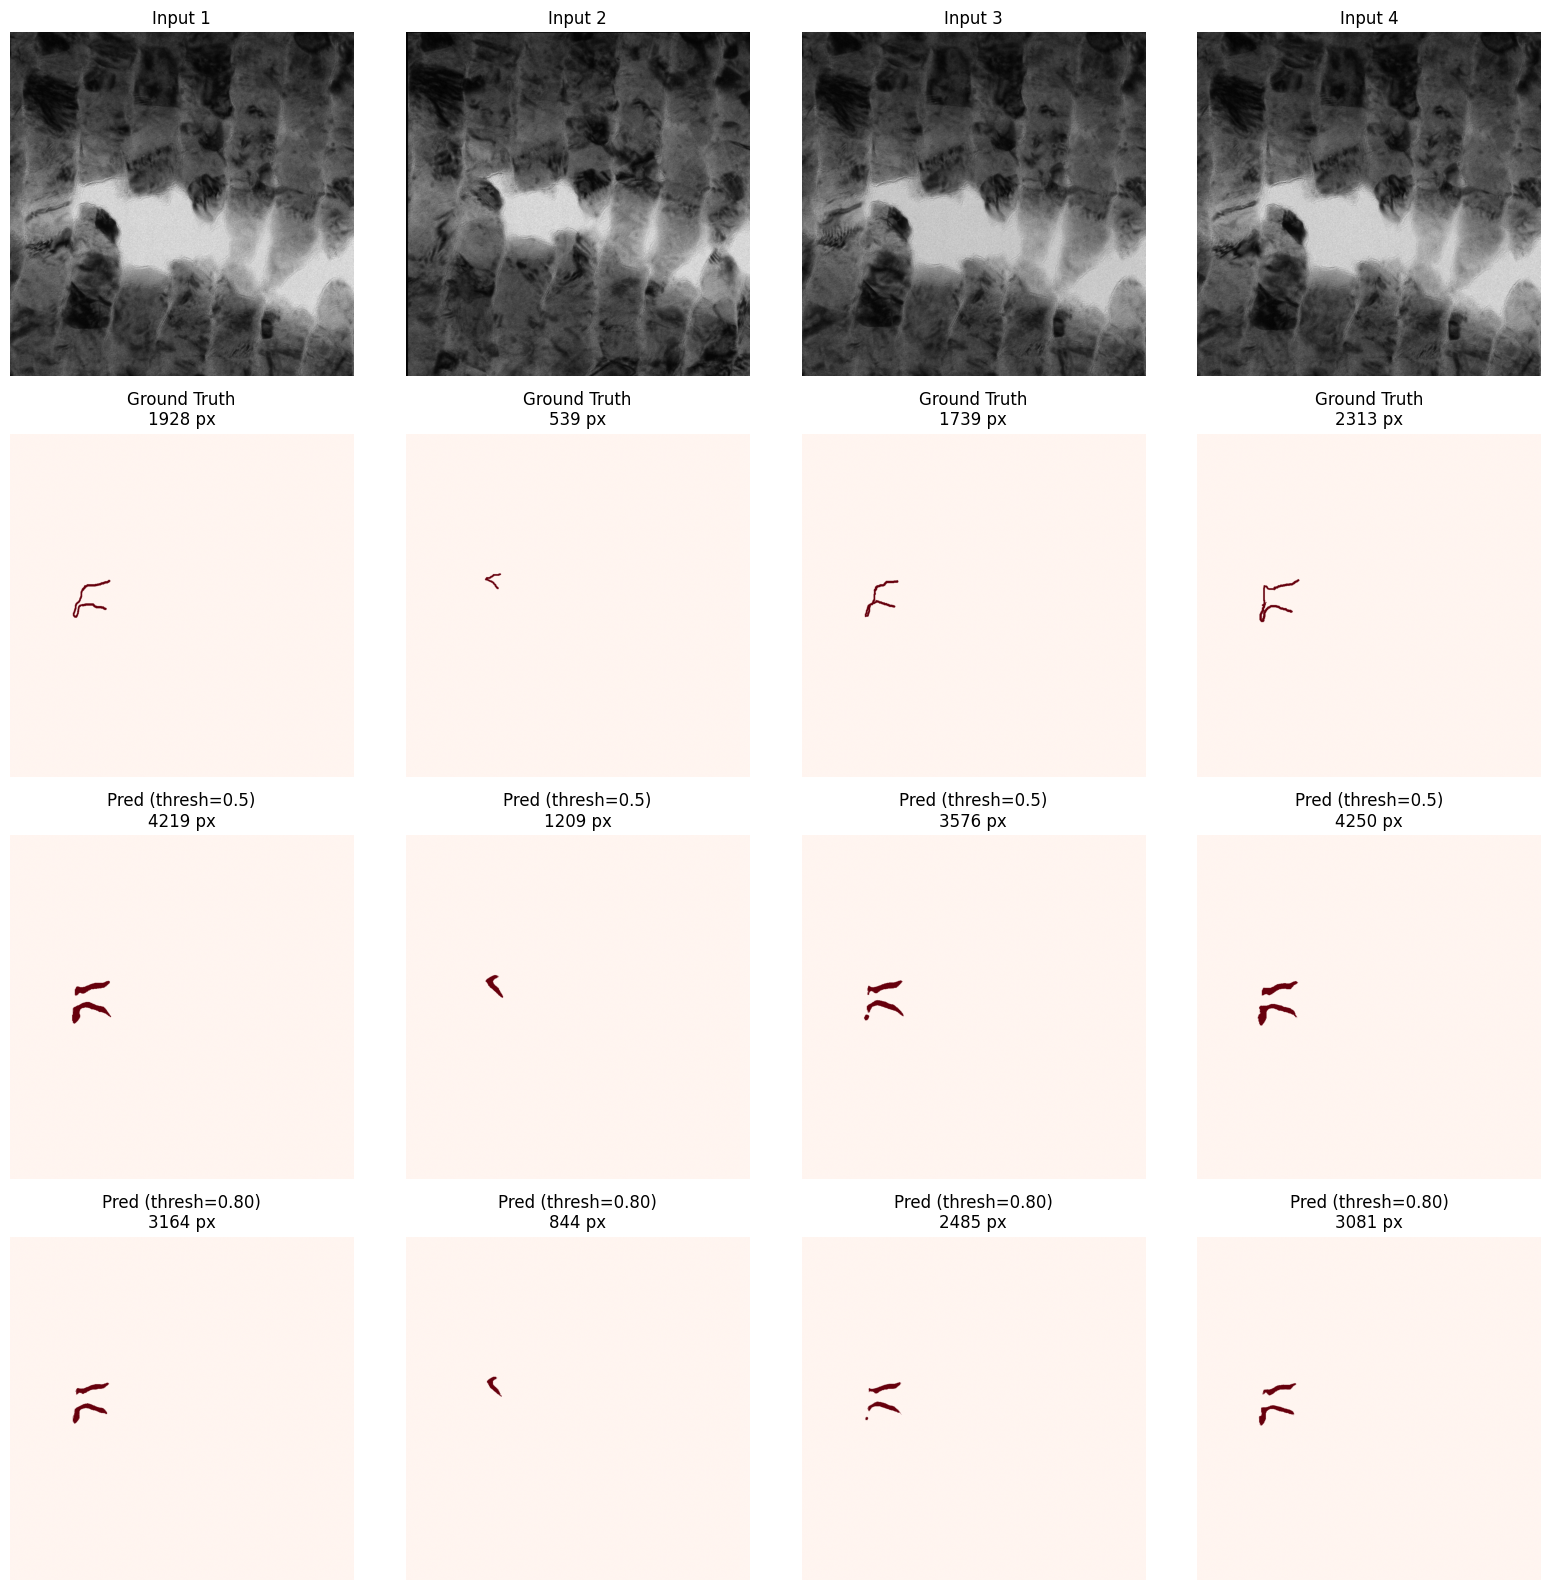

In [28]:
# Re-visualize with optimal threshold
val_images, val_masks = next(iter(val_loader))
val_images = val_images.to(device)

with torch.no_grad():
    predictions = torch.sigmoid(model(val_images))
    predictions_optimal = (predictions > optimal_threshold).float()

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(min(4, len(val_images))):
    # Original
    axes[0, i].imshow(val_images[i, 0].cpu().numpy(), cmap='gray')
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')

    # Ground truth
    gt = val_masks[i, 0].cpu().numpy()
    axes[1, i].imshow(gt, cmap='Reds')
    axes[1, i].set_title(f'Ground Truth\n{gt.sum():.0f} px')
    axes[1, i].axis('off')

    # Prediction with threshold=0.5
    pred_05 = (predictions[i, 0] > 0.5).float().cpu().numpy()
    axes[2, i].imshow(pred_05, cmap='Reds')
    axes[2, i].set_title(f'Pred (thresh=0.5)\n{pred_05.sum():.0f} px')
    axes[2, i].axis('off')

    # Prediction with optimal threshold
    pred_opt = predictions_optimal[i, 0].cpu().numpy()
    axes[3, i].imshow(pred_opt, cmap='Reds')
    axes[3, i].set_title(f'Pred (thresh={optimal_threshold:.2f})\n{pred_opt.sum():.0f} px')
    axes[3, i].axis('off')

plt.tight_layout()
plt.savefig(results_path / 'predictions_with_optimal_threshold.png', dpi=150)
plt.show()

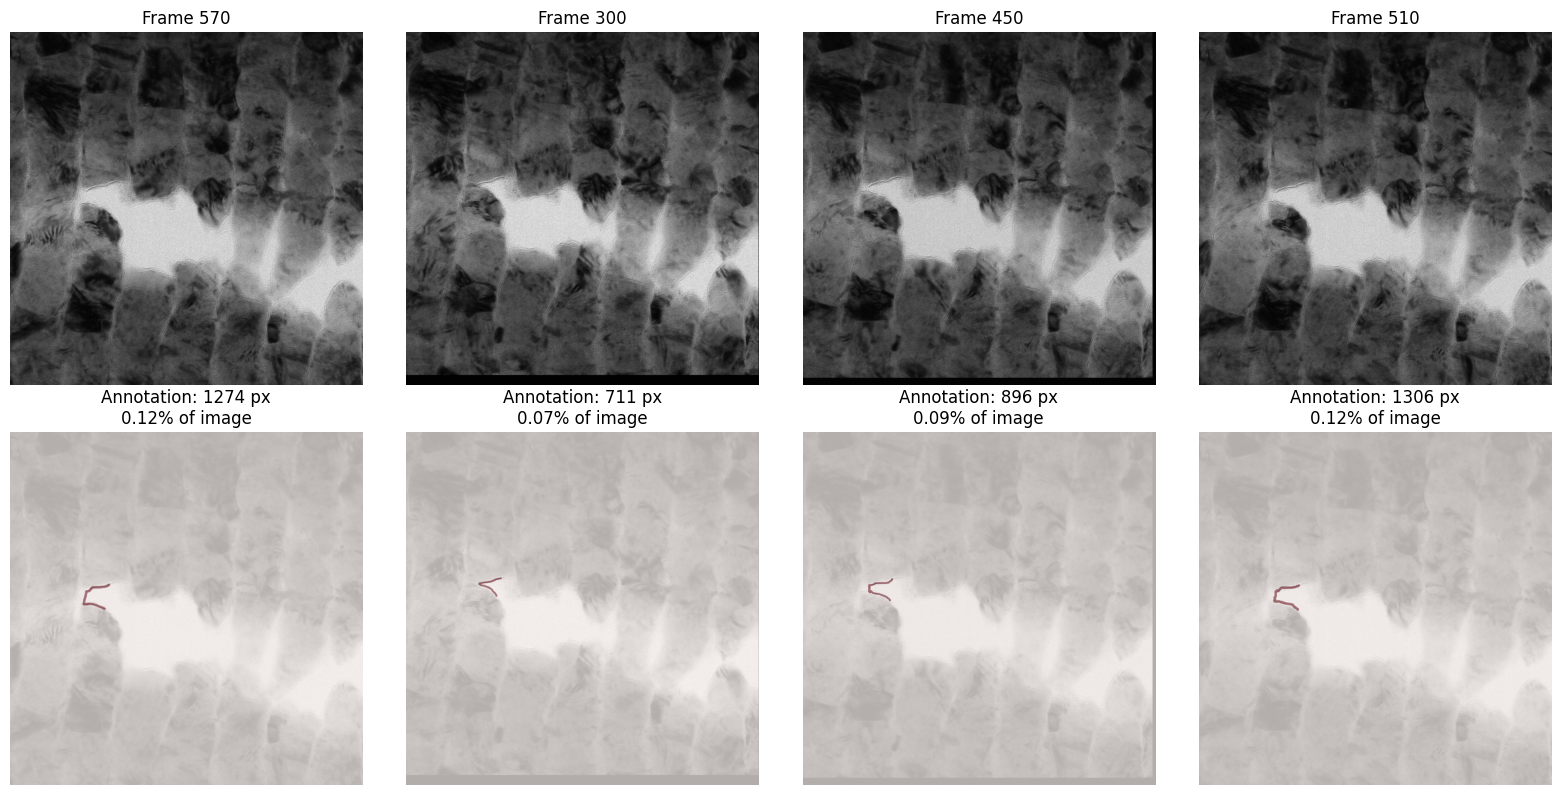

Annotation statistics:
  Mean size: 1093 pixels
  Median size: 1101 pixels
  Min size: 452 pixels
  Max size: 2313 pixels
  Std: 527 pixels


In [29]:
# Check if annotations are actually broad or if there's an issue
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Look at ground truth sizes
for i in range(4):
    idx = train_idx[i * 5]  # Sample from training set

    frame_num = frame_indices[idx]
    image = frames[frame_num]
    mask = masks[idx]

    # Show image
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].set_title(f'Frame {frame_num}')
    axes[0, i].axis('off')

    # Show mask with counts
    axes[1, i].imshow(image, cmap='gray', alpha=0.6)
    axes[1, i].imshow(mask, cmap='Reds', alpha=0.5)
    axes[1, i].set_title(f'Annotation: {mask.sum():.0f} px\n{mask.sum() / (mask.shape[0] * mask.shape[1]) * 100:.2f}% of image')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Statistics
mask_sizes = [masks[i].sum() for i in range(len(masks))]
print(f"Annotation statistics:")
print(f"  Mean size: {np.mean(mask_sizes):.0f} pixels")
print(f"  Median size: {np.median(mask_sizes):.0f} pixels")
print(f"  Min size: {np.min(mask_sizes):.0f} pixels")
print(f"  Max size: {np.max(mask_sizes):.0f} pixels")
print(f"  Std: {np.std(mask_sizes):.0f} pixels")

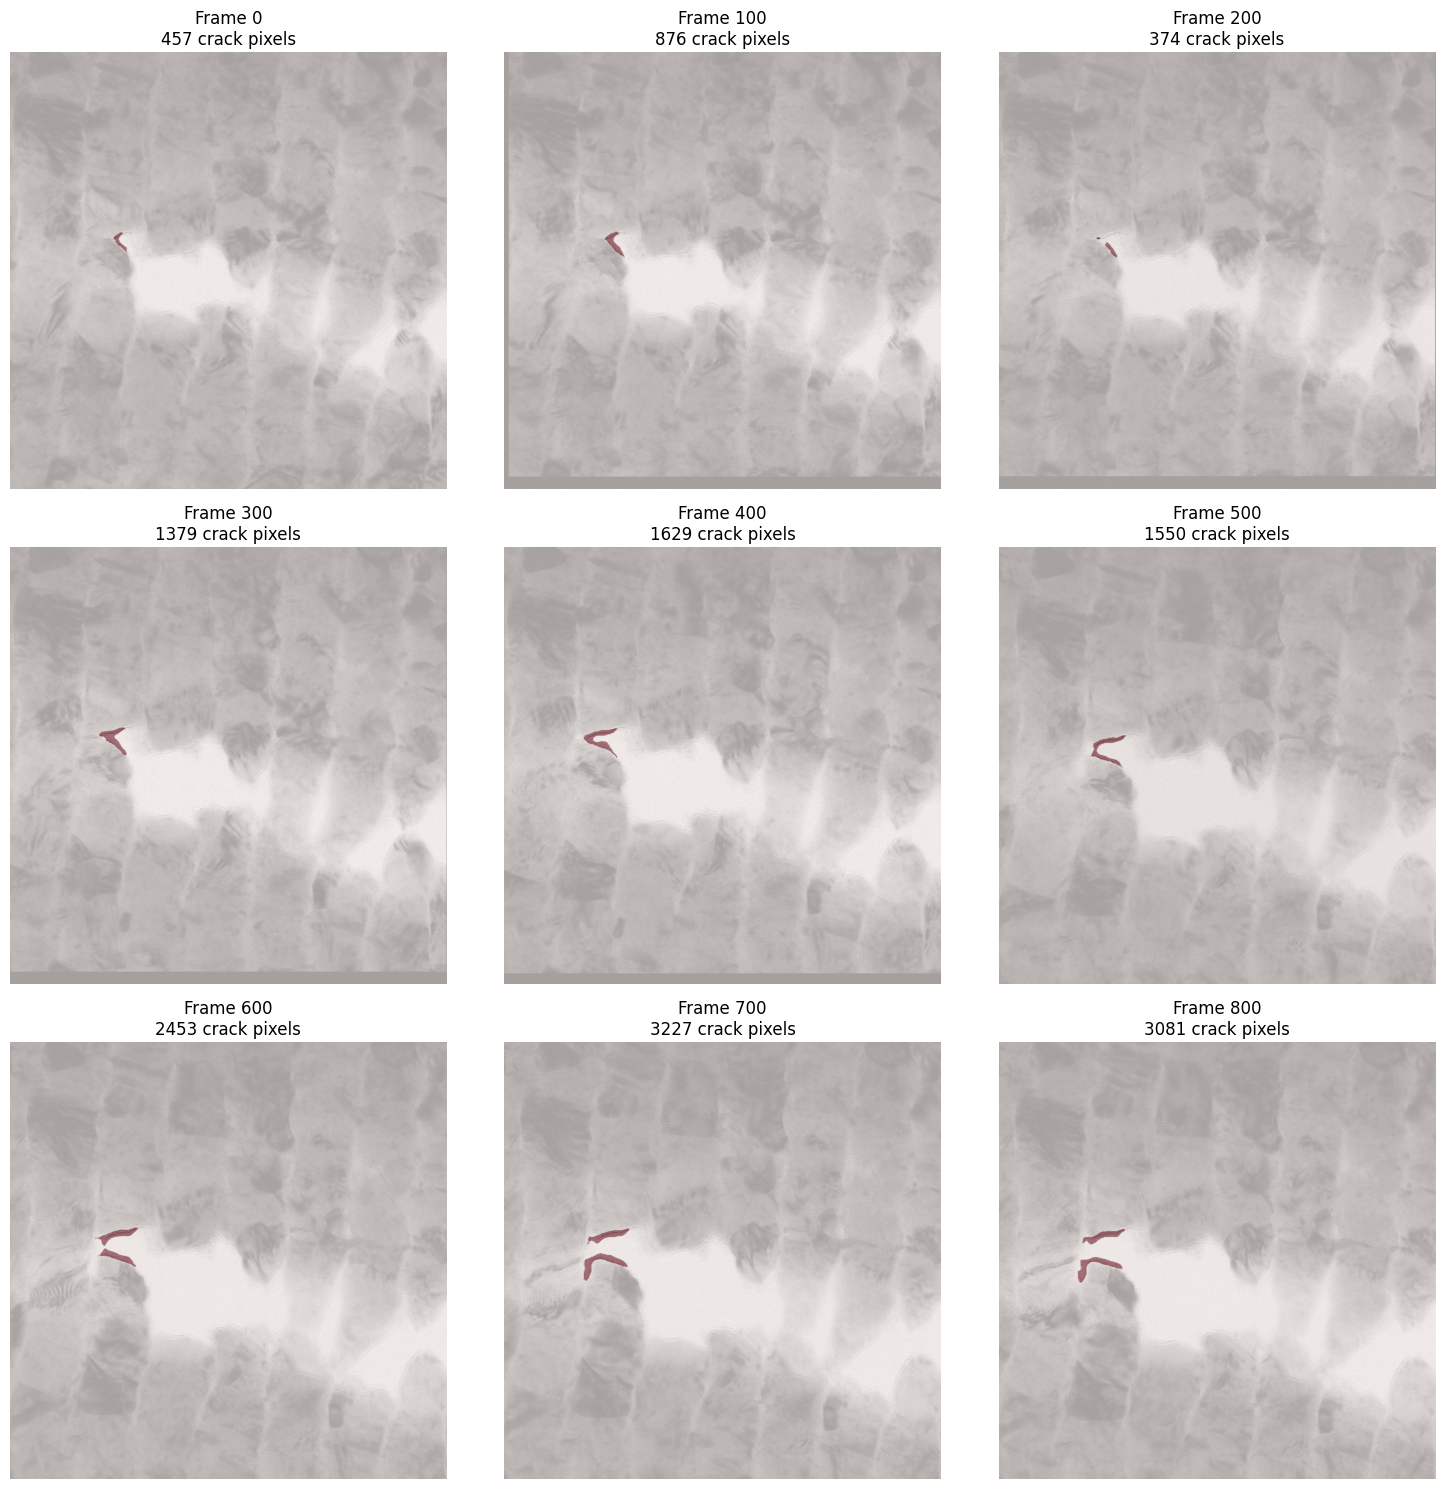

Check if predictions make sense:
  - Does it track the crack?
  - Does it grow as crack propagates?
  - Does it handle blunt regions?


In [30]:
# Predict on a few frames from original sequence
test_frames_idx = [0, 100, 200, 300, 400, 500, 600, 700, 800]  # Spread across all 855

model.eval()
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, frame_idx in enumerate(test_frames_idx):
    ax = axes.flat[i]

    # Get frame
    frame = frames[frame_idx].astype(np.float32)
    frame_norm = (frame - frame.min()) / (frame.max() - frame.min() + 1e-8)
    frame_norm = np.expand_dims(frame_norm, axis=(0, -1))  # Add batch and channel

    # Predict
    frame_tensor = torch.from_numpy(frame_norm).permute(0, 3, 1, 2).float().to(device)

    with torch.no_grad():
        pred = torch.sigmoid(model(frame_tensor))
        pred_binary = (pred > 0.80).float()  # Use optimal threshold

    # Visualize
    pred_np = pred_binary[0, 0].cpu().numpy()

    ax.imshow(frame, cmap='gray', alpha=0.7)
    ax.imshow(pred_np, cmap='Reds', alpha=0.5)
    ax.set_title(f'Frame {frame_idx}\n{pred_np.sum():.0f} crack pixels')
    ax.axis('off')

plt.tight_layout()
plt.savefig(results_path / 'inference_test_various_frames.png', dpi=150)
plt.show()

print("Check if predictions make sense:")
print("  - Does it track the crack?")
print("  - Does it grow as crack propagates?")
print("  - Does it handle blunt regions?")

In [31]:
def predict_and_postprocess(model, frame, threshold=0.80, fill_holes=True):
    """
    Predict crack mask with optional post-processing
    """
    # Normalize frame
    frame_norm = (frame - frame.min()) / (frame.max() - frame.min() + 1e-8)
    frame_tensor = torch.from_numpy(frame_norm).float().unsqueeze(0).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        pred = torch.sigmoid(model(frame_tensor))
        pred_binary = (pred > threshold).float()[0, 0].cpu().numpy()

    # Post-process
    if fill_holes:
        pred_binary = binary_fill_holes(pred_binary).astype(np.uint8)

    return pred_binary

In [32]:
# Find rightmost crack pixel
crack_pixels = np.where(mask > 0)
if len(crack_pixels[0]) > 0:
    tip_x = crack_pixels[1].max()  # Rightmost x
    tip_y_indices = crack_pixels[0][crack_pixels[1] == tip_x]
    tip_y = tip_y_indices.mean()  # Average y at tip

In [33]:
# Measure width at fixed distance behind tip
measure_distance = 30  # pixels behind tip
measure_x = tip_x - measure_distance

# Find crack pixels at this x
column = mask[:, measure_x]
crack_y = np.where(column > 0)[0]

if len(crack_y) > 0:
    ctod = crack_y.max() - crack_y.min()  # Distance between surfaces

In [34]:
# Distance from leftmost to rightmost crack pixel
crack_pixels = np.where(mask > 0)
if len(crack_pixels[1]) > 0:
    crack_length = crack_pixels[1].max() - crack_pixels[1].min()

In [37]:
from tqdm.notebook import tqdm
from scipy.ndimage import binary_fill_holes
import time
import numpy as np
import torch
import pandas as pd
from skimage import measure
from scipy.optimize import least_squares
from pathlib import Path # Ensure Path is imported for base_path
import segmentation_models_pytorch as smp # Ensure smp is imported for model

# --- Global conversion factor ---
nm_per_pixel = 0.4 # Explicitly set the conversion factor here

# --- Re-define missing variables if kernel state was lost --- START
# These variables are typically defined in earlier cells. Re-defining them here
# ensures this cell can run independently if the kernel state is lost.

# Define base_path and related paths first
if 'base_path' not in globals():
    base_path = Path('/content/drive/MyDrive/Crack_tracking')
if 'data_path' not in globals():
    data_path = base_path / 'data' / '1508 20250613 105 kx Ceta Camera.npy'
if 'annotation_path' not in globals(): # Added annotation_path as it might be used later
    annotation_path = base_path / 'annotations'
if 'results_path' not in globals():
    results_path = base_path / 'results'
    results_path.mkdir(exist_ok=True)

# Load frames if not already loaded
if 'frames' not in globals():
    print("Warning: 'frames' not found, reloading data.")
    frames = np.load(data_path, mmap_mode='r')
    print(f"Reloaded frames. Total frames: {frames.shape[0]}")

# Define sample_name
if 'sample_name' not in globals():
    sample_name = "1508_20250613_105_kx_Ceta_Camera"

# Ensure model and device are defined and loaded/initialized
if 'model' not in globals() or 'device' not in globals():
    print("Warning: Model or device not found, re-initializing them.")
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1,
        activation=None,
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    # Load best model if available to ensure it's not a fresh, untrained model
    best_model_path = results_path / f'{sample_name}_best_model.pth'
    if best_model_path.exists():
        print(f"Loading best model from {best_model_path}")
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval() # Set to eval mode after loading
    else:
        print(f"No best model found at {best_model_path}. Model remains untrained.")

# --- Re-define missing variables if kernel state was lost --- END

print("🚀 Running inference on all 855 frames...")
print("="*60)

# Inference settings
threshold = 0.80
fill_holes = True  # Post-process to connect crack surfaces

# Storage
all_predictions = np.zeros((len(frames), frames.shape[1], frames.shape[2]), dtype=np.uint8)

# Batch inference for speed
batch_size = 8
num_batches = (len(frames) + batch_size - 1) // batch_size

model.eval()
start_time = time.time()

with torch.no_grad():
    for batch_idx in tqdm(range(num_batches), desc="Inference"):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(frames))

        # Prepare batch
        batch_frames = []
        for i in range(start_idx, end_idx):
            frame = frames[i].astype(np.float32)
            frame_norm = (frame - frame.min()) / (frame.max() - frame.min() + 1e-8)
            batch_frames.append(frame_norm)

        batch_tensor = torch.from_numpy(np.array(batch_frames)).unsqueeze(1).float().to(device)

        # Predict
        predictions = torch.sigmoid(model(batch_tensor))
        predictions_binary = (predictions > threshold).cpu().numpy()

        # Post-process and store
        for i, pred in enumerate(predictions_binary):
            mask = pred[0]
            if fill_holes:
                mask = binary_fill_holes(mask).astype(np.uint8)
            all_predictions[start_idx + i] = mask

elapsed = time.time() - start_time

print("\n" + "="*60)
print(f"✅ Inference complete!")
print(f"   Time: {elapsed:.1f} seconds ({elapsed/len(frames):.3f} sec/frame)")
print(f"   Speed: {len(frames)/elapsed:.1f} frames/second")
print(f"   Total frames: {len(frames)}")
print("="*60)

# Save predictions
np.save(results_path / f'{sample_name}_all_predictions.npy', all_predictions)
print(f"\n💾 Saved predictions to: {results_path / f'{sample_name}_all_predictions.npy'}")


def extract_crack_measurements(mask):
    """
    Extract comprehensive crack measurements from binary mask

    Returns dictionary with: pixels converted to nanometers
    - tip_position: (y, x) coordinates in nm
    - crack_length: contour length in nm
    - crack_width: maximum width in nm
    - ctod: crack tip opening displacement in nm
    - tip_radius: crack tip bluntness in nm
    - crack_area: total crack area in nm^2
    """

    if mask.sum() == 0:
        return None

    # Get crack pixels
    crack_coords = np.where(mask > 0)

    if len(crack_coords[0]) == 0:
        return None

    measurements = {}

    # 1. Crack tip position (leftmost point, as crack propagates left) in nm
    tip_x_px = crack_coords[1].min()
    tip_y_candidates_px = crack_coords[0][crack_coords[1] == tip_x_px]
    tip_y_px = int(np.mean(tip_y_candidates_px))
    measurements['tip_x'] = tip_x_px * nm_per_pixel
    measurements['tip_y'] = tip_y_px * nm_per_pixel
    measurements['tip_position'] = (tip_y_px * nm_per_pixel, tip_x_px * nm_per_pixel)

    # 2. Crack length (horizontal extent) in nm
    measurements['crack_length'] = (crack_coords[1].max() - crack_coords[1].min()) * nm_per_pixel

    # 3. Crack area in nm^2
    measurements['crack_area'] = mask.sum() * (nm_per_pixel ** 2)

    # 4. CTOD - measure at multiple distances 'ahead' of the tip (to the right of tip_x) in nm
    ctod_distances_px = [10, 20, 30, 40, 50]
    ctods = {}

    for dist_px in ctod_distances_px:
        measure_x_px = tip_x_px + dist_px
        if measure_x_px >= 0 and measure_x_px < mask.shape[1]:
            column = mask[:, measure_x_px]
            crack_y = np.where(column > 0)[0]
            if len(crack_y) > 0:
                # Ensure conversion here for CTOD values
                ctods[f'ctod_{dist_px}px'] = (crack_y.max() - crack_y.min()) * nm_per_pixel
            else:
                ctods[f'ctod_{dist_px}px'] = 0.0 # Use float for nm values
        else:
            ctods[f'ctod_{dist_px}px'] = 0.0 # Use float for nm values

    measurements.update(ctods)

    # Use CTOD at 20px (converted to nm) as primary measure
    measurements['ctod'] = ctods['ctod_20px']

    # 5. Crack width (maximum vertical extent) in nm
    measurements['crack_width'] = (crack_coords[0].max() - crack_coords[0].min()) * nm_per_pixel

    # 6. Tip radius (measure of bluntness) in nm
    tip_region_size_px = 30
    y_min_px = max(0, tip_y_px - tip_region_size_px)
    y_max_px = min(mask.shape[0], tip_y_px + tip_region_size_px)
    x_min_px = max(0, tip_x_px)
    x_max_px = min(mask.shape[1], tip_x_px + tip_region_size_px)

    tip_region = mask[y_min_px:y_max_px, x_min_px:x_max_px]

    try:
        contours = measure.find_contours(tip_region, 0.5)
    except:
        contours = []

    if len(contours) > 0:
        contour = max(contours, key=len)

        if len(contour) > 5:
            def circle_residuals(params, points):
                cy, cx, r = params
                return np.sqrt((points[:, 0] - cy)**2 + (points[:, 1] - cx)**2) - r

            center_y, center_x = contour.mean(axis=0)
            initial_r = 5

            try:
                result = least_squares(
                    circle_residuals,
                    [center_y, center_x, initial_r],
                    args=(contour,),
                    bounds=([0, 0, 1], [tip_region.shape[0], tip_region.shape[1], 50])
                )
                measurements['tip_radius'] = abs(result.x[2]) * nm_per_pixel # Convert to nm
            except:
                measurements['tip_radius'] = np.nan
        else:
            measurements['tip_radius'] = np.nan
    else:
        measurements['tip_radius'] = np.nan

    return measurements

print("\n📏 Extracting measurements from all frames (in nm)...")
print("="*60)

all_measurements = []

for frame_idx in tqdm(range(len(all_predictions)), desc="Extracting measurements"):
    mask = all_predictions[frame_idx]
    measurements = extract_crack_measurements(mask)

    if measurements is not None:
        measurements['frame'] = frame_idx
        all_measurements.append(measurements)

# Convert to DataFrame
df_measurements = pd.DataFrame(all_measurements)

print("\n" + "="*60)
print(f"✅ Measurements extracted!")
print(f"   Total frames with cracks: {len(df_measurements)}")
print(f"   Measurements per frame: {len(df_measurements.columns)}")
print("="*60)

# Display summary statistics
print("\n📊 Summary Statistics (in nm and nm^2):")
print(df_measurements[['crack_length', 'crack_area', 'ctod', 'tip_radius', 'crack_width']].describe())

# Save measurements
csv_path = results_path / f'{sample_name}_measurements.csv'
df_measurements.to_csv(csv_path, index=False)
print(f"\n💾 Saved measurements to: {csv_path}")

🚀 Running inference on all 855 frames...


Inference:   0%|          | 0/107 [00:00<?, ?it/s]


✅ Inference complete!
   Time: 147.9 seconds (0.173 sec/frame)
   Speed: 5.8 frames/second
   Total frames: 855

💾 Saved predictions to: /content/drive/MyDrive/Crack_tracking/results/1508_20250613_105_kx_Ceta_Camera_all_predictions.npy

📏 Extracting measurements from all frames (in nm)...


Extracting measurements:   0%|          | 0/855 [00:00<?, ?it/s]


✅ Measurements extracted!
   Total frames with cracks: 850
   Measurements per frame: 14

📊 Summary Statistics (in nm and nm^2):
       crack_length  crack_area        ctod  tip_radius  crack_width
count    850.000000  850.000000  850.000000  848.000000   850.000000
mean      30.942118  287.092894   15.948706    8.016716    33.164235
std        9.955157  135.433579    8.537194    3.430469     9.952151
min       13.200000   16.640000    0.000000    0.450703    18.400000
25%       21.600000  160.840000   10.000000    5.157541    25.600000
50%       31.800000  274.640000   15.200000    8.309892    29.000000
75%       41.500000  390.040000   19.500000   10.291134    44.000000
max       46.400000  598.560000   42.800000   20.000000    51.600000

💾 Saved measurements to: /content/drive/MyDrive/Crack_tracking/results/1508_20250613_105_kx_Ceta_Camera_measurements.csv


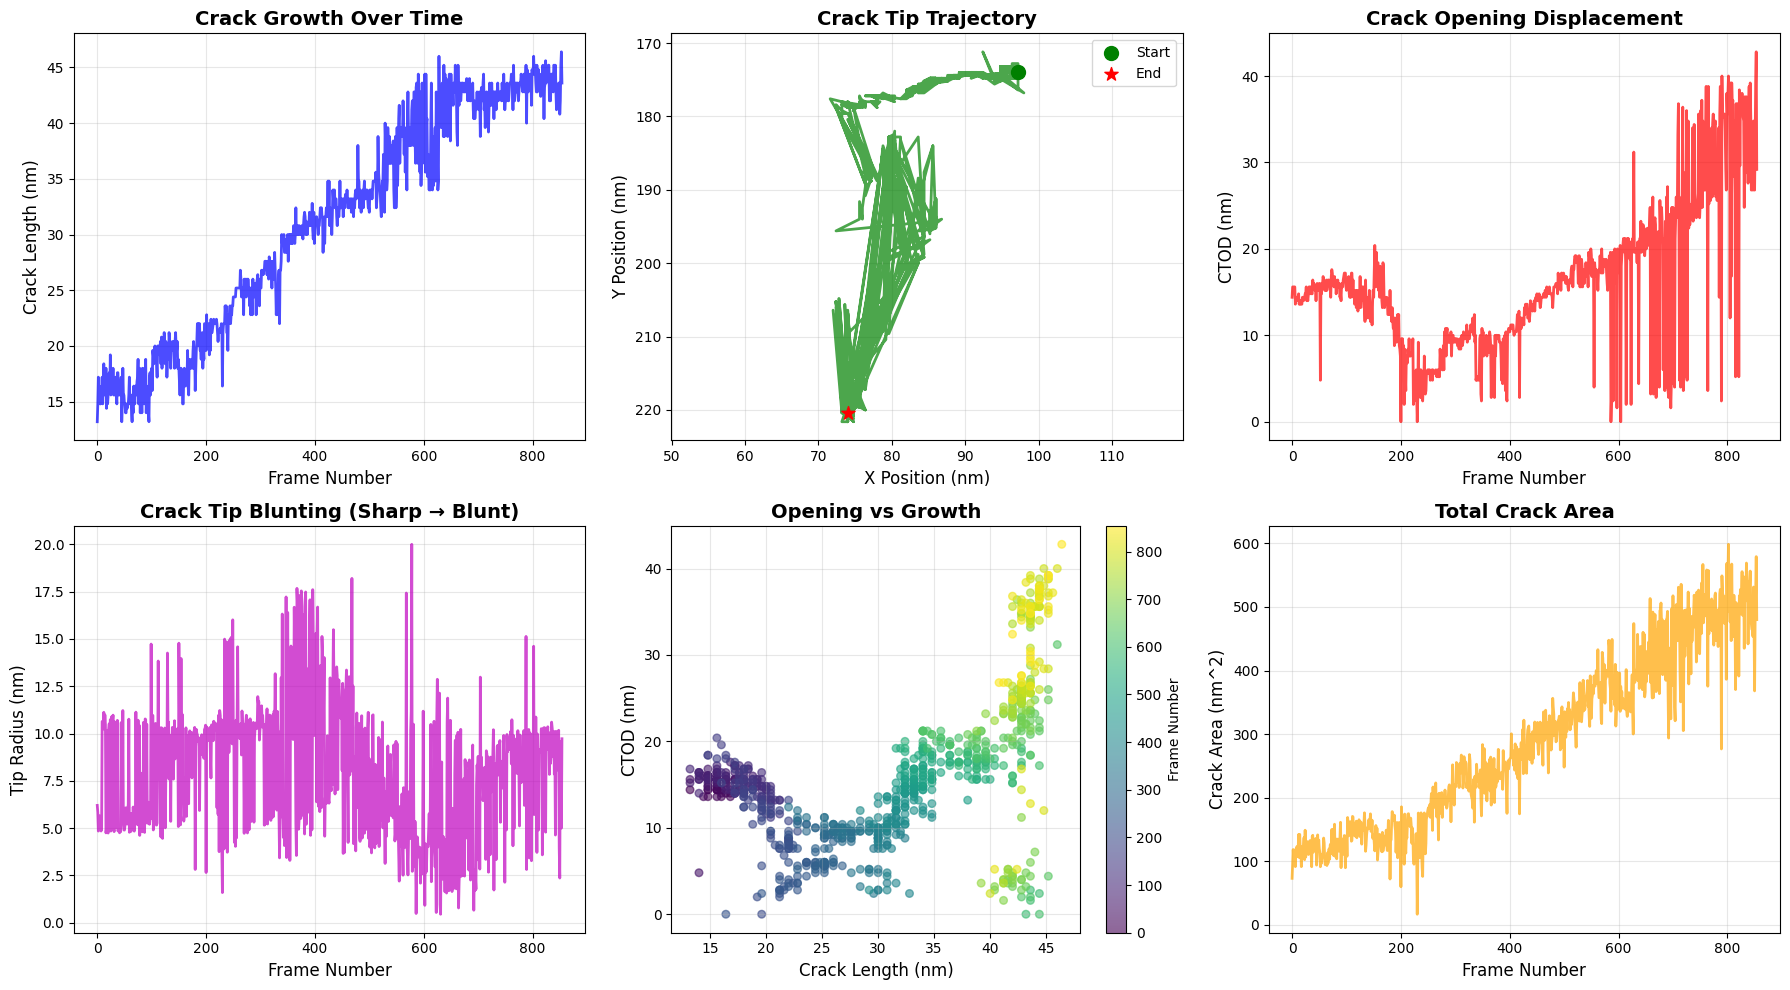

✅ Temporal evolution plots saved!


In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Crack Growth (Length)
axes[0, 0].plot(df_measurements['frame'], df_measurements['crack_length'],
                'b-', linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Frame Number', fontsize=12)
axes[0, 0].set_ylabel('Crack Length (nm)', fontsize=12)
axes[0, 0].set_title('Crack Growth Over Time', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Crack Tip Position (Trajectory)
# Note: df_measurements['tip_x'] and ['tip_y'] are already in nm
axes[0, 1].plot(df_measurements['tip_x'], df_measurements['tip_y'],
                'g-', linewidth=2, alpha=0.7)
axes[0, 1].scatter(df_measurements['tip_x'].iloc[0], df_measurements['tip_y'].iloc[0],
                   c='green', s=100, marker='o', label='Start', zorder=5)
axes[0, 1].scatter(df_measurements['tip_x'].iloc[-1], df_measurements['tip_y'].iloc[-1],
                   c='red', s=100, marker='*', label='End', zorder=5)
axes[0, 1].set_xlabel('X Position (nm)', fontsize=12)
axes[0, 1].set_ylabel('Y Position (nm)', fontsize=12)
axes[0, 1].set_title('Crack Tip Trajectory', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axis('equal')

# 3. Crack Tip Opening Displacement (CTOD)
axes[0, 2].plot(df_measurements['frame'], df_measurements['ctod'],
                'r-', linewidth=2, alpha=0.7)
axes[0, 2].set_xlabel('Frame Number', fontsize=12)
axes[0, 2].set_ylabel('CTOD (nm)', fontsize=12)
axes[0, 2].set_title('Crack Opening Displacement', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Tip Radius (Blunting)
# Filter out NaN values
df_valid_radius = df_measurements[df_measurements['tip_radius'].notna()]
axes[1, 0].plot(df_valid_radius['frame'], df_valid_radius['tip_radius'],
                'm-', linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Frame Number', fontsize=12)
axes[1, 0].set_ylabel('Tip Radius (nm)', fontsize=12)
axes[1, 0].set_title('Crack Tip Blunting (Sharp \u2192 Blunt)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. CTOD vs Crack Length
axes[1, 1].scatter(df_measurements['crack_length'], df_measurements['ctod'],
                   c=df_measurements['frame'], cmap='viridis', s=30, alpha=0.6)
axes[1, 1].set_xlabel('Crack Length (nm)', fontsize=12)
axes[1, 1].set_ylabel('CTOD (nm)', fontsize=12)
axes[1, 1].set_title('Opening vs Growth', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Frame Number', fontsize=10)

# 6. Crack Area
axes[1, 2].plot(df_measurements['frame'], df_measurements['crack_area'],
                'orange', linewidth=2, alpha=0.7)
axes[1, 2].set_xlabel('Frame Number', fontsize=12)
axes[1, 2].set_ylabel('Crack Area (nm^2)', fontsize=12)
axes[1, 2].set_title('Total Crack Area', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_path / f'{sample_name}_temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Temporal evolution plots saved!")

In [41]:
# Analyze key events
print("\n" + "="*60)
print("🔍 Key Events Analysis:")
print("="*60)

# Find when crack starts growing significantly
initial_length = df_measurements['crack_length'].iloc[:10].mean()
significant_growth = df_measurements[df_measurements['crack_length'] > initial_length * 1.5]

if len(significant_growth) > 0:
    growth_start_frame = significant_growth.iloc[0]['frame']
    print(f"\n📈 Significant crack growth starts at Frame {growth_start_frame:.0f}")

# Find maximum blunting
if len(df_valid_radius) > 0:
    max_blunting_idx = df_valid_radius['tip_radius'].idxmax()
    max_blunting_frame = df_valid_radius.loc[max_blunting_idx, 'frame']
    max_radius = df_valid_radius.loc[max_blunting_idx, 'tip_radius']
    print(f"🔵 Maximum blunting at Frame {max_blunting_frame:.0f} (radius: {max_radius:.1f} nm)")

# Find maximum CTOD
max_ctod_idx = df_measurements['ctod'].idxmax()
max_ctod_frame = df_measurements.loc[max_ctod_idx, 'frame']
max_ctod = df_measurements.loc[max_ctod_idx, 'ctod']
print(f"↕️  Maximum CTOD at Frame {max_ctod_frame:.0f} (opening: {max_ctod:.1f} nm)")

# Calculate growth rate (change in length per frame)
df_measurements['growth_rate'] = df_measurements['crack_length'].diff()
avg_growth_rate = df_measurements['growth_rate'].mean()
print(f"⚡ Average growth rate: {avg_growth_rate:.2f} nm/frame")

# Find phases
if len(df_measurements) > 100:
    # Assume sharp phase is first 1/3, transition is middle 1/3, blunt is last 1/3
    n = len(df_measurements)
    sharp_phase = df_measurements.iloc[:n//3]
    transition_phase = df_measurements.iloc[n//3:2*n//3]
    blunt_phase = df_measurements.iloc[2*n//3:]

    print(f"\n📊 Phase Analysis:")
    print(f"   Sharp phase (frames 0-{n//3}):")
    print(f"      Avg CTOD: {sharp_phase['ctod'].mean():.1f} nm")
    print(f"      Avg tip radius: {sharp_phase['tip_radius'].mean():.1f} nm")

    print(f"   Transition phase (frames {n//3}-{2*n//3}):")
    print(f"      Avg CTOD: {transition_phase['ctod'].mean():.1f} nm")
    print(f"      Avg tip radius: {transition_phase['tip_radius'].mean():.1f} nm")

    print(f"   Blunt phase (frames {2*n//3}-{n}):")
    print(f"      Avg CTOD: {blunt_phase['ctod'].mean():.1f} nm")
    print(f"      Avg tip radius: {blunt_phase['tip_radius'].mean():.1f} nm")

print("="*60)


🔍 Key Events Analysis:

📈 Significant crack growth starts at Frame 235
🔵 Maximum blunting at Frame 578 (radius: 20.0 nm)
↕️  Maximum CTOD at Frame 853 (opening: 42.8 nm)
⚡ Average growth rate: 0.04 nm/frame

📊 Phase Analysis:
   Sharp phase (frames 0-283):
      Avg CTOD: 12.1 nm
      Avg tip radius: 8.3 nm
   Transition phase (frames 283-566):
      Avg CTOD: 12.5 nm
      Avg tip radius: 9.0 nm
   Blunt phase (frames 566-850):
      Avg CTOD: 23.3 nm
      Avg tip radius: 6.8 nm



🎥 Creating visualization of crack evolution...


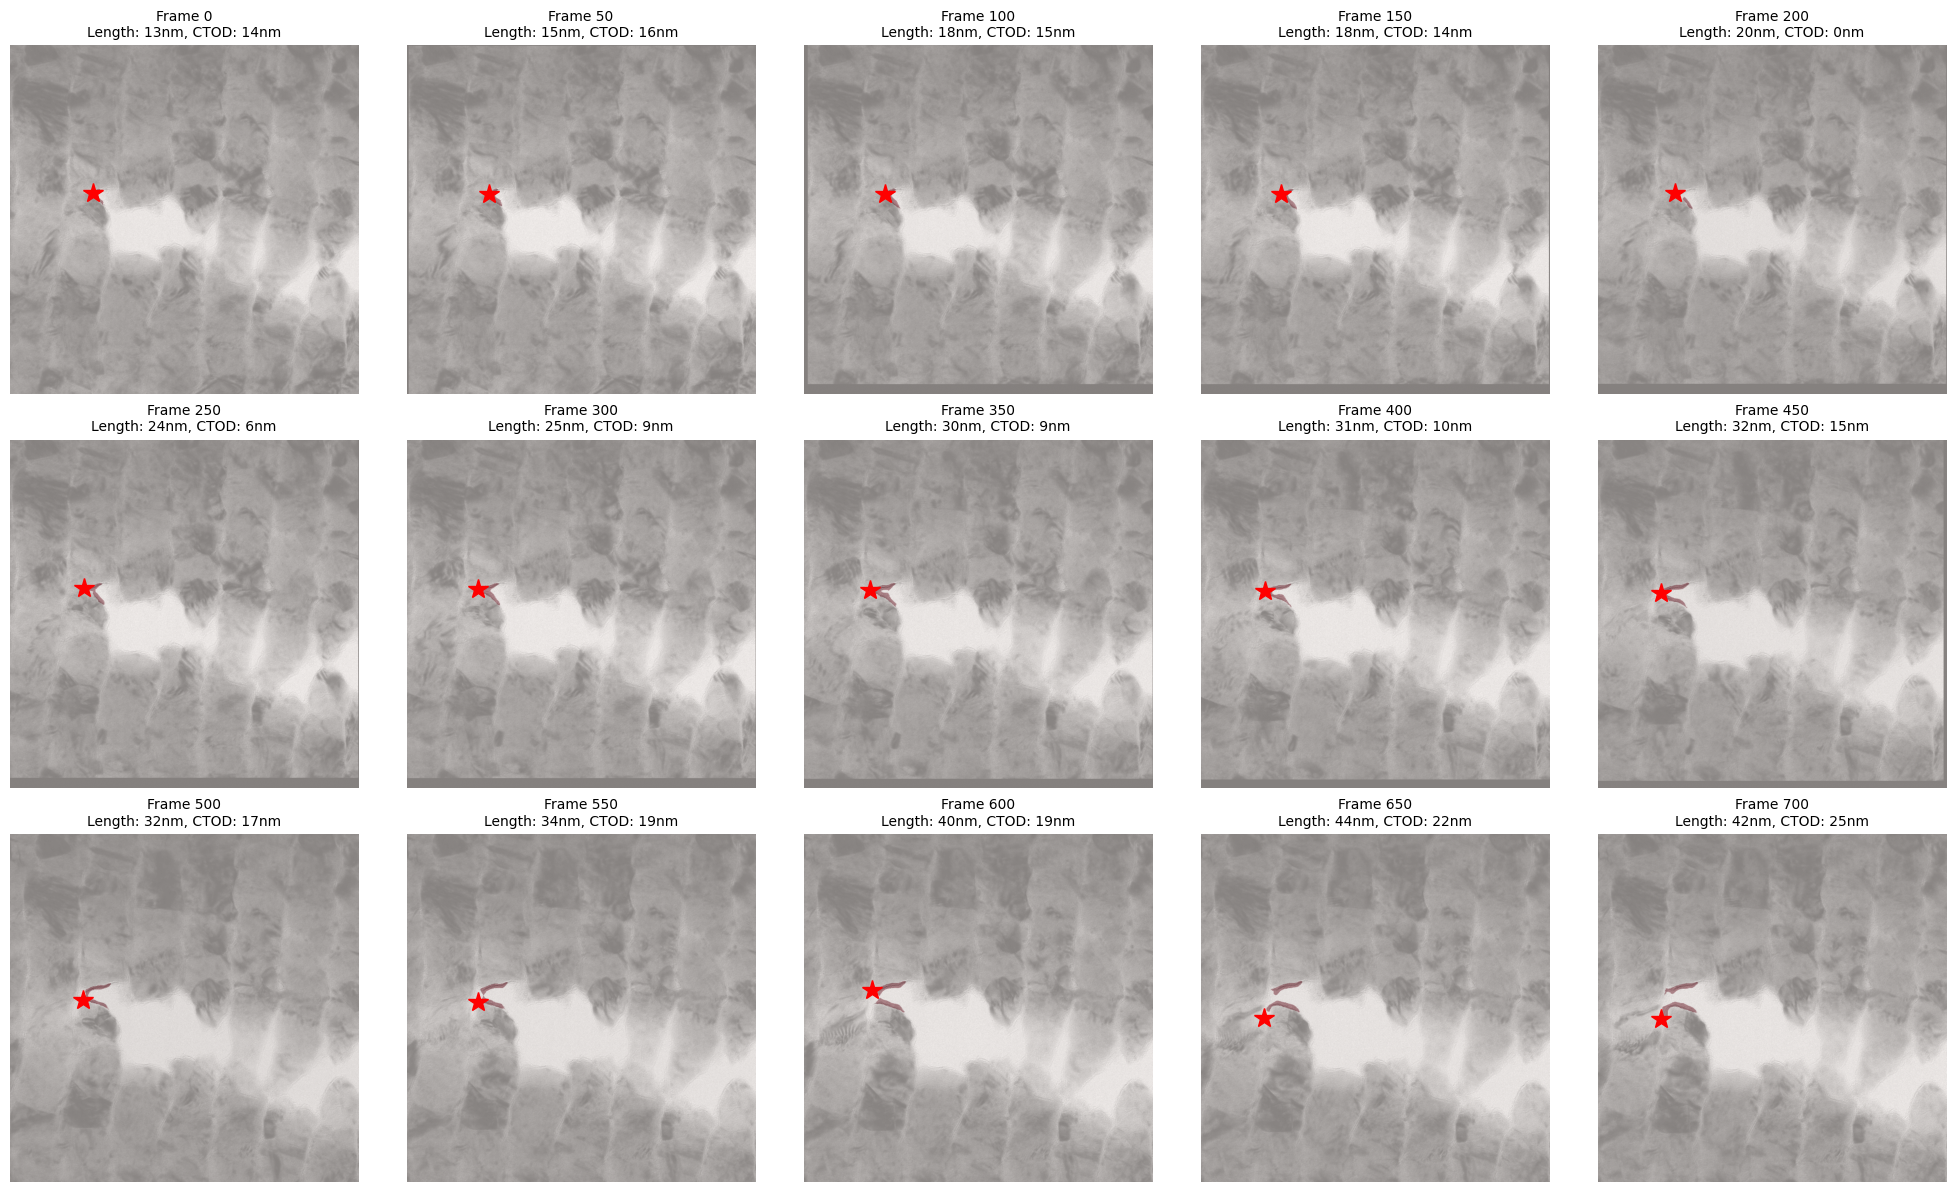

✅ Visualization complete!


In [44]:
# Create a video showing crack evolution with overlay
print("\n🎥 Creating visualization of crack evolution...")

# Select frames to show (every 50th frame)
vis_frames = list(range(0, len(frames), 50)) # Changed interval from 20 to 50

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

# Ensure nm_per_pixel is defined, as it's needed for reverse conversion for plotting
# This assumes nm_per_pixel has been defined in a preceding cell like RGLJMzb_Rwzn
if 'nm_per_pixel' not in globals():
    nm_per_pixel = 0.4 # Default value if not found

for idx, frame_num in enumerate(vis_frames[:15]):  # Show 15 frames
    if idx >= len(axes):
        break

    frame = frames[frame_num]
    mask = all_predictions[frame_num]

    # Get measurements for this frame
    frame_data = df_measurements[df_measurements['frame'] == frame_num]

    # Overlay
    axes[idx].imshow(frame, cmap='gray', alpha=0.8)
    axes[idx].imshow(mask, cmap='Reds', alpha=0.4)

    # Mark tip - Convert nm back to pixels for plotting on the image
    if len(frame_data) > 0:
        # tip_x and tip_y from df_measurements are in nm, convert back to pixels
        tip_x_nm = frame_data.iloc[0]['tip_x']
        tip_y_nm = frame_data.iloc[0]['tip_y']

        tip_x_px = tip_x_nm / nm_per_pixel
        tip_y_px = tip_y_nm / nm_per_pixel

        axes[idx].plot(tip_x_px, tip_y_px, 'r*', markersize=15)

        # Add info, using nm values for labels
        length = frame_data.iloc[0]['crack_length']
        ctod = frame_data.iloc[0]['ctod']
        axes[idx].set_title(f'Frame {frame_num}\nLength: {length:.0f}nm, CTOD: {ctod:.0f}nm',
                           fontsize=10)
    else:
        axes[idx].set_title(f'Frame {frame_num}', fontsize=10)

    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(results_path / f'{sample_name}_evolution_montage.png', dpi=200, bbox_inches='tight')
plt.show()

print("✅ Visualization complete!")

In [30]:
print("\n" + "="*60)
print("🎉 DAY 1 COMPLETE - SUMMARY")
print("="*60)
print(f"\n📁 Files created:")
print(f"   1. {sample_name}_all_predictions.npy - Segmentation masks (855 frames)")
print(f"   2. {sample_name}_measurements.csv - All measurements")
print(f"   3. {sample_name}_temporal_analysis.png - Evolution plots")
print(f"   4. {sample_name}_evolution_montage.png - Visual summary")
print(f"   5. {sample_name}_best_model_v2.pth - Trained model (if retrained)")

print(f"\n📊 Measurements extracted:")
print(f"   - Crack tip position (x, y)")
print(f"   - Crack length")
print(f"   - CTOD (at multiple distances)")
print(f"   - Tip radius (bluntness)")
print(f"   - Crack area")
print(f"   - Crack width")

print(f"\n✅ Ready for:")
print(f"   - Compare with other samples (30nm, 60nm, 120nm)")
print(f"   - Physical interpretation")
print(f"   - Hackathon presentation")

print("\n" + "="*60)
print("⏱️  Time for Day 2: Comparative analysis & presentation!")
print("="*60)


🎉 DAY 1 COMPLETE - SUMMARY

📁 Files created:
   1. 1508_20250613_105_kx_Ceta_Camera_all_predictions.npy - Segmentation masks (855 frames)
   2. 1508_20250613_105_kx_Ceta_Camera_measurements.csv - All measurements
   3. 1508_20250613_105_kx_Ceta_Camera_temporal_analysis.png - Evolution plots
   4. 1508_20250613_105_kx_Ceta_Camera_evolution_montage.png - Visual summary
   5. 1508_20250613_105_kx_Ceta_Camera_best_model_v2.pth - Trained model (if retrained)

📊 Measurements extracted:
   - Crack tip position (x, y)
   - Crack length
   - CTOD (at multiple distances)
   - Tip radius (bluntness)
   - Crack area
   - Crack width

✅ Ready for:
   - Compare with other samples (30nm, 60nm, 120nm)
   - Physical interpretation
   - Hackathon presentation

⏱️  Time for Day 2: Comparative analysis & presentation!
